In [52]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import imageio.v3 as iio

In [53]:
# Load original image.
Uorig = iio.imread("flowgray.png").astype(np.float64)

# If the image loads as RGB, convert to grayscale (MATLAB imread on a grayscale PNG gives 2D).
if Uorig.ndim == 3:
    Uorig = Uorig[..., :3]
    Uorig = 0.299 * Uorig[..., 0] + 0.587 * Uorig[..., 1] + 0.114 * Uorig[..., 2]

m, n = Uorig.shape

# How much of the image is known
percent_mask = 0.5
np.random.seed(1029)  # roughly analogous to MATLAB rand('state',1029)
Known = np.random.rand(m, n) < percent_mask

In [54]:
Ul2 = cp.Variable((m, n))
constraints = []
for i in range(m):
    for j in range(n):
        if Known[i, j]:
            constraints.append(Ul2[i, j] == Uorig[i, j])

loss = 0
for i in range(1, m):
    for j in range(1, n):
        loss += cp.square(Ul2[i, j] - Ul2[i - 1, j]) + cp.square(
            Ul2[i, j] - Ul2[i, j - 1]
        )

objective = cp.Minimize(loss)
problem = cp.Problem(objective, constraints)
problem.solve()
problem.status

'optimal'

In [55]:
problem.value, Ul2.value

(np.float64(28464780.304123703),
 array([[255.        , 255.        , 255.        , ..., 255.        ,
         255.        , 255.        ],
        [255.        , 255.        , 255.        , ..., 255.        ,
         255.        , 255.        ],
        [255.        , 255.        , 253.80418914, ..., 255.        ,
         255.        , 255.        ],
        ...,
        [255.        , 255.        , 255.        , ..., 254.95600557,
         254.82402229, 255.        ],
        [255.        , 255.        , 255.        , ..., 255.        ,
         255.        , 255.        ],
        [255.        , 255.        , 255.        , ..., 255.        ,
         255.        , 255.        ]], shape=(51, 59)))

In [56]:
Utv = cp.Variable((m, n))
constraints = []
for i in range(m):
    for j in range(n):
        if Known[i, j]:
            constraints.append(Utv[i, j] == Uorig[i, j])

loss = 0
for i in range(1, m):
    for j in range(1, n):
        loss += cp.abs(Utv[i, j] - Utv[i - 1, j]) + cp.abs(Utv[i, j] - Utv[i, j - 1])

objective = cp.Minimize(loss)
problem = cp.Problem(objective, constraints)
problem.solve()
problem.status

'optimal'

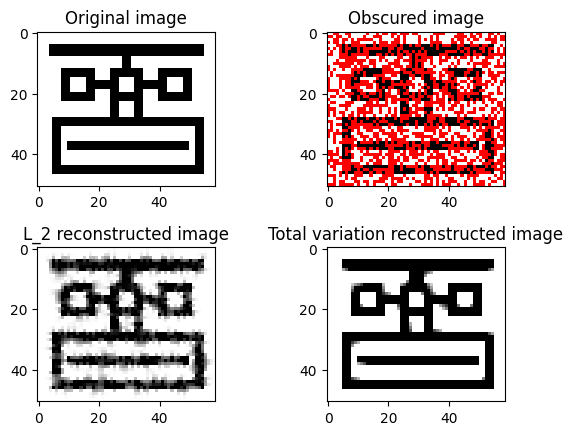

In [57]:
# Graph everything.
plt.figure(1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.clf()
plt.set_cmap("gray")

plt.subplot(2, 2, 1)
plt.imshow(Uorig)
plt.title("Original image")
plt.axis("image")

plt.subplot(2, 2, 2)
plt.imshow(Uorig, cmap="gray", vmin=0, vmax=255)
unknown = ~Known
overlay = np.zeros((m, n, 4), dtype=float)  # RGBA
overlay[..., 0] = 1
overlay[..., 3] = unknown.astype(float) * 1  # alpha only where unknown
plt.imshow(overlay)
# plt.imshow(Known * Uorig + 256 - 150 * Known)
plt.title("Obscured image")
plt.axis("image")

plt.subplot(2, 2, 3)
plt.imshow(Ul2.value)
plt.title("L_2 reconstructed image")
plt.axis("image")

plt.subplot(2, 2, 4)
plt.imshow(Utv.value)
plt.title("Total variation reconstructed image")
plt.axis("image")

plt.show()